In [5]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [6]:
!unzip -uq "/content/drive/MyDrive/Test.zip" -d "/content/sample_data/Test_images/"

In [7]:
!unzip -uq "/content/drive/MyDrive/Train.zip" -d "/content/sample_data/Train_images/"

Load images


In [8]:
from keras.preprocessing.image import  img_to_array, load_img
size = (256,256)
folder="/content/sample_data/Test_images/Test/"
test_images = []
for filename in os.listdir(folder):
  test_images.append(load_img(os.path.join(folder,filename), target_size=size))
len(test_images)

494

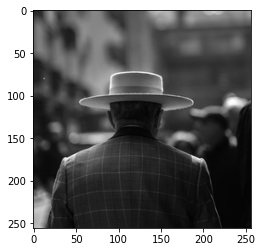

In [9]:
from matplotlib.pyplot import imshow
imshow(test_images[23])

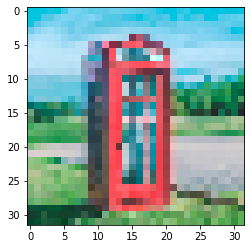

In [42]:
from keras.preprocessing.image import  img_to_array, load_img
size = (32,32)
folder="/content/sample_data/Train_images/Train/"
train_images = []
i = 0
for filename in os.listdir(folder):
  train_images.append(load_img(os.path.join(folder,filename), target_size=size))
imshow(train_images[23])
  

Convert each image in the array into numpy arrays

In [43]:
train_data = []

for img in train_images:
  train_data.append(img_to_array(img))

train_data = np.array(train_data, dtype=float)
def MinMax(train_data,labels=["R","G","B"]):
    print("______________________________")
    for i, lab in enumerate(labels):
        mi = np.min(train_data[:,:,:,i])
        ma = np.max(train_data[:,:,:,i])
        print("{} : MIN={:8.4f}, MAX={:8.4f}".format(lab,mi,ma))
        
MinMax(train_data,labels=["R","G","B"])

______________________________
R : MIN=  0.0000, MAX=255.0000
G : MIN=  0.0000, MAX=255.0000
B : MIN=  0.0000, MAX=255.0000


Process to be done for the colorization of black and white images:

1.   Convert all training images from the RGB color space to the Lab color space.
2.   Use the Y channel as the input to the network and train the network to predict the correct ab channels
3.   Combine the input Y channel with the predicted a and b channels.
4.   Finally convert the Lab image back to RGB image.

In [44]:
train = train_data/255.0
MinMax(train,labels=["R","G","B"]) 

______________________________
R : MIN=  0.0000, MAX=  1.0000
G : MIN=  0.0000, MAX=  1.0000
B : MIN=  0.0000, MAX=  1.0000



*   Convert images into Lab colorspace and scale values to range -1,1
*   Lab colorspace has value ranges 0,100 in L and -128,128 in ab



---





Split the channels so that the L channel is in X and ab in Y


In [45]:
from skimage.color import rgb2lab

train = rgb2lab(train)

In [46]:
MinMax(train, labels=["L","a","b"])

______________________________
L : MIN=  0.0000, MAX=100.0000
a : MIN=-85.6701, MAX= 97.5394
b : MIN=-106.9306, MAX= 93.8682


In [47]:
trainX = train[:,:,:,0]
trainY = train[:,:,:,1:]
trainY = trainY / 128.0

In [49]:
trainY = trainY.reshape(9294,32,32,2)
trainX = trainX.reshape(9294,32,32,1)

In [50]:
MinMax(trainY, labels=["a","b"]),
MinMax(trainX, labels="L")

______________________________
a : MIN= -0.6693, MAX=  0.7620
b : MIN= -0.8354, MAX=  0.7333
______________________________
L : MIN=  0.0000, MAX=100.0000


Lab values are now in range -1,1

In [88]:
model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(None,None,1)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=(2,2)),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=(2,2)),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=(2,2)),
      tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      tf.keras.layers.UpSampling2D((2,2),),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      tf.keras.layers.UpSampling2D((2,2),),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
      tf.keras.layers.UpSampling2D((2,2),),
      tf.keras.layers.Conv2D(2, (3,3), activation='tanh', padding='same'),
])

In [ ]:
model.summary()

In [89]:
model.compile(optimizer='rmsprop',loss='mse',
              metrics='accuracy')

In [ ]:
model.fit(x=trainX, y=trainY, batch_size=24, epochs=200, validation_split=0.15)


In [91]:
loss, acc = model.evaluate(trainX,  trainY, verbose=2)

print('\naccuracy:', acc)
print('\nloss:', loss)

291/291 - 1s - loss: 0.0043 - accuracy: 0.7222

accuracy: 0.7221800684928894

loss: 0.004327049944549799


Test the model by predicting on an image

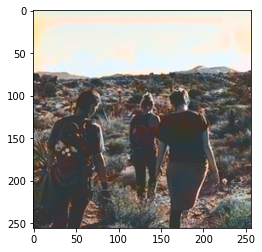

In [124]:
from skimage.color import lab2rgb
from matplotlib.pyplot import imsave,imshow
from PIL import Image


test_img = load_img('../content/test2.jpg')
test_img = img_to_array(np.array(test_img, dtype=float))
test = test_img/255.0
test = rgb2lab(test)[:,:,0]
test = test.reshape(1,256,256,1)

result = model.predict(test)
result *= 128 #revert ab pixel-scale from -1,1 back to -128,128

pic = np.zeros((256,256,3)) # initialize an empty array for the result image
pic[:,:,0] = test[0][:,:,0] #take the L channel from the input
pic[:,:,1:] = result[0] # take the ab channels from the output
#MinMax(pic.reshape(1,256,256,3), labels=['L', 'A', 'B'])
result_pic = lab2rgb(pic)
#MinMax(result_pic.reshape(1,256,256,3), labels=['R', 'G', 'B'])
imshow(result_pic)
imsave("drive/MyDrive/results/colored_tree.png", result_pic)